# How to make your Levels in Mario Maker Popular?

## Wrangling, Cleaning, and Preliminary Look at Data

In [1]:
#data wrangling
import numpy as np
import pandas as pd
import datetime

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#ML libraries
#TODO: Sort out which ones we really need
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#other utilities
import os

We got the data in normalized CSVs from the [SMMNet](https://www.kaggle.com/leomauro/smmnet) dataset on Kaggle.
First, we want to read in the data and have a quick glance at what the separate tables look like.

In [2]:
data_dir = os.fsencode('./data/')

In [3]:
#read in he CSV files containing the data
#TODO: Abstract and build as function for util_pkg
df_dict = {}
for filename in os.listdir(data_dir):
    filepath_str = str(os.fsdecode(os.path.join(data_dir,filename)))
    df_name_str = str(os.fsdecode(os.path.splitext(filename)[0]))
    df_dict[df_name_str] = pd.read_csv(filepath_str, sep = '\t')
    print(df_name_str)

plays
players
courses
records
clears
likes
course-meta


In [4]:
#get an overview of the data we just pulled and drop unnecessary ones
for df in df_dict:
    print(df)
    print(df_dict[df].shape)
    display(df_dict[df].head())

plays
(3941378, 3)


,catch,id,player
0,2018-02-23 15:22:44.015,0000-0000-0353-3D35,darter60k
1,2018-02-23 15:22:44.015,0000-0000-0353-3D35,davidchofis
2,2018-02-23 15:22:44.015,0000-0000-0353-3D35,fabioviana
3,2018-02-23 15:22:44.015,0000-0000-0353-3D35,gorigokky
4,2018-02-23 15:22:44.015,0000-0000-0353-3D35,groebenzell


players
(884302, 4)


,id,image,flag,name
0,NolramImpro,http://mii-images.cdn.nintendo.net/3nhht3y6sjm...,BR,Nolram
1,SGK2017,http://mii-images.cdn.nintendo.net/4bxo1rny12r...,JP,しげ
2,preamstrikbiz0,http://mii-images.cdn.nintendo.net/2i0nphr806h...,US,primo
3,gotatari,http://mii-images.cdn.nintendo.net/2dvhs41zz7y...,JP,たくと
4,skrufpanda,http://mii-images.cdn.nintendo.net/2n2gr4n7oxg...,NO,pinkachuz


courses
(115032, 8)


,id,difficulty,gameStyle,maker,title,thumbnail,image,creation
0,079D-0000-0351-17E2,expert,marioBros3,NolramImpro,Apocalipse 14:12,https://dypqnhofrd2x2.cloudfront.net/079D-0000...,https://dypqnhofrd2x2.cloudfront.net/079D-0000...,2017-08-11 00:00:00
1,07CD-0000-030D-EA60,expert,marioBrosU,igorsssa,Dangerous Ship Fantasy,https://dypqnhofrd2x2.cloudfront.net/07CD-0000...,https://dypqnhofrd2x2.cloudfront.net/07CD-0000...,2017-03-11 00:00:00
2,07F7-0000-030F-A51B,superExpert,marioWorld,Wiggle133,Pow-Ing (Speedrun) (^o^),https://dypqnhofrd2x2.cloudfront.net/07F7-0000...,https://dypqnhofrd2x2.cloudfront.net/07F7-0000...,2017-03-14 00:00:00
3,080E-0000-0307-A394,expert,marioBros,vitorotavio,desafios radcore,https://dypqnhofrd2x2.cloudfront.net/080E-0000...,https://dypqnhofrd2x2.cloudfront.net/080E-0000...,2017-02-26 00:00:00
4,082F-0000-0358-A218,normal,marioBros3,CaptainToad4444,Goodbye Miiverse...,https://dypqnhofrd2x2.cloudfront.net/082F-0000...,https://dypqnhofrd2x2.cloudfront.net/082F-0000...,2017-08-29 00:00:00


records
(117126, 4)


,catch,id,player,timeRecord
0,2017-12-18 15:35:29.015,F68A-0000-0337-AF4F,The_Brucican,15482
1,2018-03-02 10:09:32.392,9669-0000-0330-554C,inoino2226,9265
2,2017-12-18 15:47:40.665,0D1D-0000-0355-DA7A,hbeeboy,6692
3,2018-02-23 15:02:20.557,18E3-0000-032A-27AB,Khazey,40383
4,2018-02-23 15:05:16.414,2C55-0000-0300-854A,okayan3378,1533


clears
(2051809, 3)


,catch,id,player
0,2018-02-23 15:22:44.015,0000-0000-0353-3D35,darter60k
1,2018-02-23 15:22:44.015,0000-0000-0353-3D35,davidchofis
2,2018-02-23 15:22:44.015,0000-0000-0353-3D35,fabioviana
3,2018-02-23 15:22:44.015,0000-0000-0353-3D35,groebenzell
4,2018-02-23 15:22:44.015,0000-0000-0353-3D35,igatake0229


likes
(618687, 3)


,catch,id,player
0,2018-02-23 15:22:44.015,0000-0000-0353-3D35,groebenzell
1,2018-03-02 09:46:27.847,0000-0000-035A-9F14,jlan6e
2,2017-12-18 14:47:47.489,0001-0000-0347-486A,cat38690
3,2017-12-18 14:47:47.489,0001-0000-0347-486A,raulcaba
4,2017-12-18 14:47:48.878,0001-0000-0359-B3CD,Tugaeddy


course-meta
(292298, 10)


,catch,id,firstClear,tag,stars,players,tweets,clears,attempts,clearRate
0,2017-11-16 14:45:36.703,079D-0000-0351-17E2,SGK2017,NaN,1,16,0,2,58,3.44
1,2017-11-16 14:45:38.342,07CD-0000-030D-EA60,emerson1312,NaN,1,22,0,2,120,1.66
2,2017-11-16 14:45:40.259,07F7-0000-030F-A51B,jacobrw420,NaN,9,69,0,7,903,0.77
3,2017-11-16 14:45:42.023,080E-0000-0307-A394,Alef_Nascimento,NaN,2,27,0,4,93,4.30
4,2017-11-16 14:45:43.414,082F-0000-0358-A218,Thunder8966,NaN,1,11,0,2,19,10.52


We also want to check for potential `NaN`s in each table

In [5]:
def check_null_cols(df_dict):
    #TODO: write a docstring
    
    for df in df_dict:
        print(df)
        display(pd.DataFrame((np.sum(df_dict[df].isnull())/df_dict[df].shape[0])))

check_null_cols(df_dict)

plays


,0
catch,0.0
id,0.0
player,0.0


players


,0
id,0.000000
image,0.000000
flag,0.000000
name,0.000011


courses


,0
id,0.000000
difficulty,0.000000
gameStyle,0.000000
maker,0.000661
title,0.000026
thumbnail,0.000000
image,0.000000
creation,0.000000


records


,0
catch,0.0
id,0.0
player,0.0
timeRecord,0.0


clears


,0
catch,0.0
id,0.0
player,0.0


likes


,0
catch,0.0
id,0.0
player,0.0


course-meta


,0
catch,0.000000
id,0.000000
firstClear,0.014119
tag,0.882394
stars,0.000000
players,0.000000
tweets,0.000000
clears,0.000000
attempts,0.000000
clearRate,0.000000


Using the relational diagram on the [SMMNet project page](https://www.kaggle.com/leomauro/smmnet) gives us a good idea of how we need to join the data, what columns we can drop to handle "slimmer" dataframes and what we need to watch out for, when cleaning the data.
A short overview of what happens in the following cells:

1. We will only take the most recent observation from `course-meta`, as each course appears several times with different metrics. In addition, we will drop the columns `tag` as it contains a bunch of `NaN`s, and `catch`, as we won't need it after having made sure that we end up with one record per course. As there are only few `NaN`s in the column `firstClear`, we are going to drop those rows.

2. For `courses`, we will drop the `image` and `thumbnail` link, as well as the `title`, as they will only provide us with little information without the use of NLP or image learning.

3. For similar reasons, we drop the `image` and `name` columns from `players`.

In [6]:
# drop tags from course-meta... too many nulls
# TODO: also drop entries from course and course meta with catch < max(catch)
# for the others just drop rows missing value

# to drop:
#  - all earlier entries of a course - we only want the most recent one
#      solution from : https://stackoverflow.com/a/51820845
#  - columns we won't need thereafter
#  - potentially remaining duplicates
course_meta_df = df_dict['course-meta'].\
                    sort_values(by = ['id', 'catch']).\
                    drop_duplicates(subset=['id'], keep = 'last').\
                    drop(columns = ['tag', 'catch']).\
                    dropna(subset = ['firstClear'], axis = 0).\
                    drop_duplicates()

course_df = df_dict['courses'].\
                drop(columns = ['thumbnail', 'image', 'title']).\
                dropna(subset = ['maker'], axis = 0).\
                drop_duplicates()

course_complete_df = course_meta_df.merge(course_df, on = 'id')

players_df = df_dict['players'].drop(columns = ['image', 'name']).\
                rename(columns= {'id' : 'player_id'}).\
                drop_duplicates()



In [7]:
#get player flags
course_complete_df = course_complete_df.merge(players_df,
                                             how = 'left',
                                             left_on = 'maker',
                                             right_on = 'player_id')

print(course_complete_df.shape)
print(course_complete_df.columns)

(113122, 14)
Index(['id', 'firstClear', 'stars', 'players', 'tweets', 'clears', 'attempts',
       'clearRate', 'difficulty', 'gameStyle', 'maker', 'creation',
       'player_id', 'flag'],
      dtype='object')


In the end, we end up with *113122 rows and 14 columns*. A quick check confirms that everything went as expected and we have all the info we need.

In [8]:
course_complete_df.head()

,id,firstClear,stars,players,tweets,clears,attempts,clearRate,difficulty,gameStyle,maker,creation,player_id,flag
0,0000-0000-0353-3D35,groebenzell,1,13,0,9,27,33.33,normal,marioBrosU,Raphael160908,2017-08-16 00:00:00,Raphael160908,FR
1,0000-0000-035A-9F14,moonbear89,1,13,0,4,37,10.81,normal,marioWorld,Mr.loom,2017-09-03 00:00:00,Mr.loom,DE
2,0001-0000-0347-486A,cat38690,2,28,0,25,47,53.19,easy,marioBrosU,alirab,2017-07-19 00:00:00,alirab,CA
3,0001-0000-0359-B3CD,BHcrew4708,1,13,0,6,24,25.00,normal,marioBrosU,SmithsOnForchuk,2017-09-01 00:00:00,SmithsOnForchuk,CA
4,0002-0000-0328-E374,ishindenshin217,3,33,0,28,66,42.42,easy,marioBros,FOOTBALLEUR3.0,2017-04-30 00:00:00,FOOTBALLEUR3.0,FR


Now we can start by looking at some descriptive metrics that are easy to compute from our complete dataframe. Using the graphs below, we can draw the following conclusions:
1. Most courses in our dataset were contributed by French accounts.
2. Most courses wer graded as `normal` in terms of their difficulty.
3. The timeframe of our data ranges from 2017/02/11 ~ 2018/04/09
4. Interestingly, only a comparatively small subset of flags that were present among players are also present as course creators. It is hard to imagine that accounts from other countries didn't contribute courses, as this is the main premise and USP of Super Mario Maker, so the dataset seemed to limit itself in some way to creators from those four countries.

In [9]:
country_counts = course_complete_df.flag.value_counts()
difficulty_counts = course_complete_df.difficulty.value_counts() 

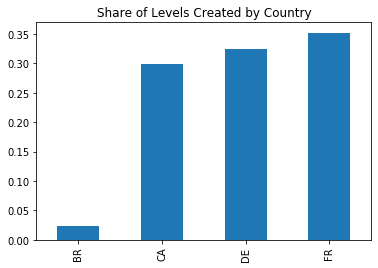

In [10]:
(country_counts/course_complete_df.shape[0]).sort_values().plot(kind = 'bar')
plt.title("Share of Levels Created by Country");

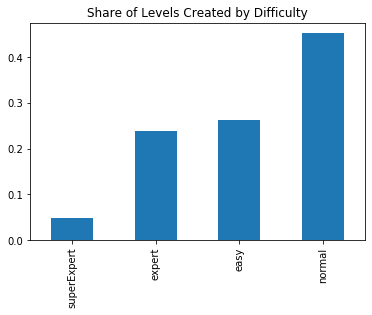

In [11]:
(difficulty_counts/course_complete_df.shape[0]).sort_values().plot(kind = 'bar')
plt.title("Share of Levels Created by Difficulty");

In [12]:
print(course_complete_df.creation.max(), course_complete_df.creation.min())

2018-04-09 11:03:11.789 2017-02-11 23:00:00


In [13]:
course_complete_df.flag.unique()

array(['FR', 'DE', 'CA', 'BR'], dtype=object)

In [14]:
players_df.flag.unique()

array(['BR', 'JP', 'US', 'NO', 'CA', 'FR', 'DE', 'HN', 'MX', 'BE', 'GB',
       'NL', 'DK', 'IT', 'SE', 'RU', 'FI', 'ES', 'GT', 'CL', 'PT', 'AT',
       'AU', 'PL', 'IE', 'PE', 'VE', 'NZ', 'CO', 'HR', 'SI', 'CH', 'DO',
       'BG', 'CR', 'PA', 'EC', 'GR', 'LU', 'PY', 'ZA', 'TR', 'HU', 'AR',
       'BO', 'SV', 'AI', 'RO', 'SK', 'EE', 'LC', 'UY', 'LT', 'VI', 'CZ',
       'CY', 'TT', 'NI', 'BB', 'GY', 'HT', 'MT', 'DM', 'LV', 'BM', 'AG',
       'BS', 'AW', 'BZ', 'GF', 'KY', 'MQ', 'AN', 'GD', 'GP', 'VG', 'VC',
       'JM', 'SR', 'MS', 'KN', 'TC'], dtype=object)

## What makes courses successful in terms of stars and tweets?

To answer the questions above, we can go ahead and try to build simple models to predict stars and tweets, look at how well they perform and extract coefficient estimates for the independent variables to see, which of them our models consider to have the strongest influence on the number of stars and tweets. Before we do this, there are a few necessary steps to do:

1. It is most probably of relevance to know, *who* made a particular level. However, with the large number of creators present in our dataset, it doesn't make sense to transform them into a dummy variable as we would risk overparametrizing the model. To still operationalize the info, we would get out of the creator's ID, we will construct a variable counting how many courses a given creator has created. Naively assuming that we can use this proxy to catch some kind of "experiene" in creating courses, we have an easily useable numeric variable.

2. To have `scikit-learn` properly handle the date variable `creation`, we need to transform the `datetime` into a numeric variable by transforming it into the number of days between a courses creation and the earliest date in our dataframe. This transformation preserves the underlying ordering and the information we are looking for in `creation`.

3. We should also drop `clears` (or `attempts` or `clearRate`), as we have the linear relationship `clears = attempts*(clearRate/100)`. This would pose a problem for the model

4. For the remaining categorical variables, we need to extract corresponding dummy variables.

In [15]:
# extract number of courses created and add as extra column
course_complete_df['courses_by_maker'] = course_complete_df.groupby('maker').transform('count').id

# operationalize age of course relative to earliest date in df in days
course_complete_df['creation'] = pd.to_datetime(course_complete_df.creation)
course_complete_df['normalized_age'] = (course_complete_df.creation - course_complete_df.creation.min()).dt.days

In [16]:
course_clean_df = course_complete_df.drop(columns = 
                ['firstClear', 'id', 'maker', 'player_id', 'clears', 'creation'])

# also drop clears... the info is not needed as we have 
# clears = attempts*(clearRate/100)

# we're dropping maker here although it might be useful...
# use somewhere else in analysis
# we should also extract creation in a meaningful way.
course_clean_df.head()

,stars,players,tweets,attempts,clearRate,difficulty,gameStyle,flag,courses_by_maker,normalized_age
0,1,13,0,27,33.33,normal,marioBrosU,FR,4,185
1,1,13,0,37,10.81,normal,marioWorld,DE,1,203
2,2,28,0,47,53.19,easy,marioBrosU,CA,4,157
3,1,13,0,24,25.00,normal,marioBrosU,CA,1,201
4,3,33,0,66,42.42,easy,marioBros,FR,3,77


In [17]:
# split columns into num_ and cat_

cat_cols = ['difficulty', 'gameStyle', 'flag']
num_cols = [col for col in course_clean_df.columns if col not in cat_cols]
# gives the right result and doesnt require us to split the df

In [18]:
#taken from lectures
def get_dummy_df(df, cat_cols, dummy_na=True):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for column in cat_cols:
        
        try:
            df = pd.concat([df.drop(column, axis = 1), pd.get_dummies(df[column], dummy_na=dummy_na, prefix = column, 
                                                                     prefix_sep = "_", drop_first = True)], axis = 1)
        except:
            continue
            
    return df
            

    

In [19]:
course_final_df = get_dummy_df(course_clean_df, cat_cols, False) # already checked, there are no NaNs left
course_final_df.head()

,stars,players,tweets,attempts,clearRate,courses_by_maker,normalized_age,difficulty_expert,difficulty_normal,difficulty_superExpert,gameStyle_marioBros3,gameStyle_marioBrosU,gameStyle_marioWorld,flag_CA,flag_DE,flag_FR
0,1,13,0,27,33.33,4,185,0,1,0,0,1,0,0,0,1
1,1,13,0,37,10.81,1,203,0,1,0,0,0,1,0,1,0
2,2,28,0,47,53.19,4,157,0,0,0,0,1,0,1,0,0
3,1,13,0,24,25.00,1,201,0,1,0,0,1,0,1,0,0
4,3,33,0,66,42.42,3,77,0,0,0,0,0,0,0,0,1


With this cleaned and prepared dataset, we can then proceed to estimate two linear models; one for the stars and one for the tweets.

In [20]:
# prepare for linreg

y_stars = course_final_df.stars
y_tweets = course_final_df.tweets

X_stars = course_final_df.drop(columns = ['stars'])
X_tweets = course_final_df.drop(columns = ['tweets'])

X_stars_train, X_stars_test, y_stars_train, y_stars_test = train_test_split(X_stars, y_stars, 
                                                                            test_size = .33, random_state = 23)

X_tweets_train, X_tweets_test, y_tweets_train, y_tweets_test = train_test_split(X_tweets, y_tweets, 
                                                                            test_size = .33, random_state = 23)

lm_stars = LinearRegression(normalize=True).fit(X_stars_train,y_stars_train)
lm_tweets = LinearRegression(normalize=True).fit(X_tweets_train,y_tweets_train)

y_stars_train_preds = lm_stars.predict(X_stars_train)
y_stars_test_preds = lm_stars.predict(X_stars_test)

y_tweets_train_preds = lm_tweets.predict(X_tweets_train)
y_tweets_test_preds = lm_tweets.predict(X_tweets_test)

train_score_stars = r2_score(y_stars_train, y_stars_train_preds)
test_score_stars = r2_score(y_stars_test, y_stars_test_preds)

train_score_tweets = r2_score(y_tweets_train, y_tweets_train_preds)
test_score_tweets = r2_score(y_tweets_test, y_tweets_test_preds)

In [21]:
out = \
'R2 Training (Stars): \t' + str(train_score_stars) + '\n' +\
'R2 Testing (Stars): \t' + str(test_score_stars) + '\n' +\
'R2 Training (Tweets): \t' + str(train_score_tweets) + '\n' +\
'R2 Testing (Tweets): \t' + str(test_score_tweets) + '\n'

In [22]:
print(out)

R2 Training (Stars): 	0.9151698072435811
R2 Testing (Stars): 	0.9316487024188472
R2 Training (Tweets): 	0.009056441928940617
R2 Testing (Tweets): 	0.019974109518443472



Our model for the stars seems to work out almost too well! It's explaining the training data very well and also does a good job extending to new datasets. 
The model for predicting the number of tweets, however, is a different story. It performs very poorly. Probably the model is missing some information, like the `firstClear` player, or players, who cleared the level in general, as some of those might be influencers. However, including those variables as dummy does not seem to be the optimal way to proceed here. For predicting the number of tweets, we might need other analytical tools, such as network analysis or something similar to identify players driving tweets.

Now that we have estimated our linear models, we can proceed to have a look at the estimated coefficients to identify drivers of the number of stars (and - taking the results with a grain of salt - also of the number of tweets)

In [23]:
def coef_weights(model, coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = model.coef_
    coefs_df['abs_coefs'] = np.abs(model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


In [24]:
#Use the function
coef_stars_df = coef_weights(lm_stars, lm_stars.coef_, X_stars_train)

#A quick look at the top results
coef_stars_df.head(20)

,est_int,coefs,abs_coefs
8,difficulty_superExpert,-3.872263,3.872263
6,difficulty_expert,-2.541356,2.541356
1,tweets,2.343754,2.343754
7,difficulty_normal,-1.510019,1.510019
10,gameStyle_marioBrosU,-1.187663,1.187663
11,gameStyle_marioWorld,-0.502811,0.502811
9,gameStyle_marioBros3,-0.497774,0.497774
13,flag_DE,0.292258,0.292258
4,courses_by_maker,0.168090,0.168090
0,players,0.134016,0.134016


To properly interpret the coefficients of the catecorical values here, we always have to keep in mind the one category we had dropped before, as we compare *all other categories against that one*. For our coefficients, that means that levels from Germany tend to get more stars than levels submitted by US users, whereas levels submitted from France and Canada compare worse to them.
Just judging from the coefficients, we can conclude that harder levels get - everything else being equal - less stars than easy levels.
Unsurprisingly, levels that get tweeted more often reach more people and thus receive more stars. Also, a level being made in the style of classic Super Mario Bros.
Finally, we could also confirm our hypothesis that courses by more seasoned creators receive more stars.

In [25]:
coef_tweets_df = coef_weights(lm_tweets, lm_tweets.coef_, X_tweets_train)

#A quick look at the top results
coef_tweets_df.head(20)

,est_int,coefs,abs_coefs
13,flag_DE,2.746550e-03,2.746550e-03
11,gameStyle_marioWorld,-1.697140e-03,1.697140e-03
7,difficulty_normal,-1.329622e-03,1.329622e-03
14,flag_FR,-9.957347e-04,9.957347e-04
9,gameStyle_marioBros3,-7.601220e-04,7.601220e-04
12,flag_CA,-5.062937e-04,5.062937e-04
4,courses_by_maker,4.098261e-04,4.098261e-04
8,difficulty_superExpert,-3.990646e-04,3.990646e-04
6,difficulty_expert,-1.448894e-04,1.448894e-04
0,stars,4.234684e-05,4.234684e-05


## Are stars and tweets driven by the same level characteristics?

The coefficients we got for the tweets model are much smaller and - considering our R squared - to be interpreted with caution. But already the fact that the almost same set of predictors yielded such a different outcome in terms of predictive power tells us that *whether a course gets shared on Twitter* is likely driven by other factors (and probably also mechanisms, i.e. a different model altogether) than the number of stars it receives.
The few factors, they seem to share are:

1. Courses from German creators receive more tweets.
2. Easy courses are more popular.
3. More seasoned creators seem to be more likely to produce 'twitterworthy' courses.

## Are there differences across countries in the most played game styles?

Another interesting question to ask is whether the creators from the four countries in our dataset prefer the same game styles and difficulties, or if different countries might have different tastes when it comes to these factors. Using the number of courses created for each category and the sum of stars given in each category, we can check if there are differences for creators, as well as players.

In [26]:
def barplot_country_course_count(df, country_labels, metrics):
    for country in country_labels:
        subset_df = df[df.flag == country]
        nrows = subset_df.shape[0]
        
        fig, axs = plt.subplots(1, len(metrics))
        fig.suptitle(country)
        fig.set_figwidth(8)
    
        for metric, ax in zip(metrics,axs.flat):
            count = subset_df[metric].value_counts()/nrows
            ax.barh(count.index, count.values)
            for tick in ax.get_yticklabels():
                tick.set_rotation(45)
                
            fig.tight_layout(pad=2.0)

### Which levels are the most popular among makers?

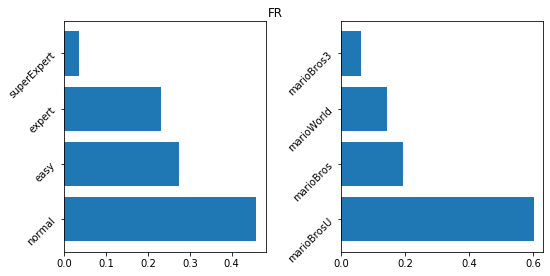

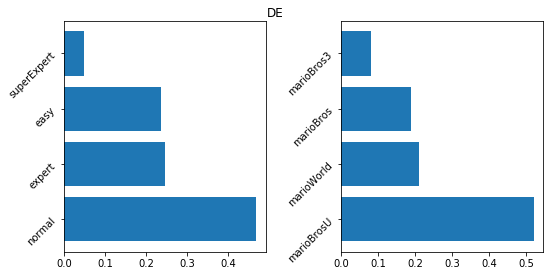

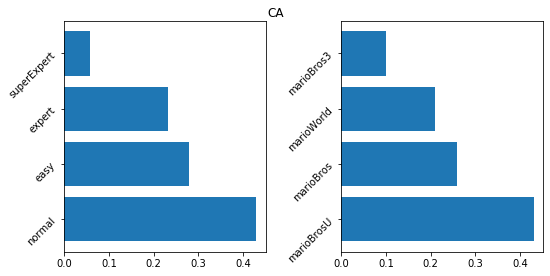

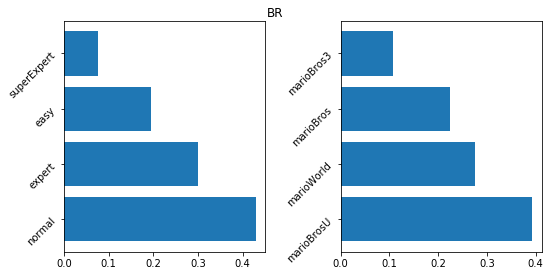

In [27]:
countries = list(course_complete_df.flag.unique())
barplot_country_course_count(course_complete_df, countries,
                            ['difficulty', 'gameStyle'])

Both the most popular difficulty (`normal`) and style (`marioBrosU`) are the same across all countries. Differences only occur for ranks 2 and 3. interestingly, they seem to occur at the same time, i.e. countries with `expert` levels being the second-most popular, also have `marioWorld` as the second-most popular course style.

### Which levels are the most popular among players?

In [28]:
barplot_country_star_sum(course_complete_df, countries,
           fig.set_figwidth(8),['difficulty', 'gameStyle'])

NameError: name 'barplot_country_star_sum' is not defined